# Sunspot RNN
1. Download and explore data
2. Preproceess data if needed
3. Create a dataset with group of inputs of some size (between 10 and 50) - Similar to this [example](https://colab.research.google.com/drive/1tj0DRWxVvRC7_b7ubQ46zJo4ZuxT4jbW?authuser=1)
4. Split the data into train and test
5. Use 3 different RNN type

In [38]:
#!wget https://storage.googleapis.com/nicksdemobucket/sunspots.csv

# OR

#!wget https://storage.googleapis.com/nicksdemobucket/temperatures.csv

# OR MNIST

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Conv1D, LSTM, GRU, SimpleRNN
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.metrics import mean_squared_error
from keras.optimizers import SGD, Adam

# The following piece of code gives the opportunity to show multiple outputs
# in one cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import random
random.seed(42)

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/silpai/McGill_DataScience_ML_Certificate/main/Sunspots.csv',index_col=[0])
df.rename({"Date": "Date", "Monthly Mean Total Sunspot Number": 'Mean_sunspot'}, axis=1, inplace=True)
df["Date"]=pd.to_datetime(df["Date"])
df["Mean_sunspot"]=df["Mean_sunspot"].astype("float")
df.set_index('Date', inplace=True) # index date
df.head()
print("# of rows:", df.shape[0])


df2 = df.copy().reset_index()
# computing a 1y rolling average
df2['1y_rolling_avg'] = df2.Mean_sunspot.rolling(365).mean()

df2.head()

,Mean_sunspot
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


# of rows: 3265


,Date,Mean_sunspot,1y_rolling_avg
0,1749-01-31,96.7,NaN
1,1749-02-28,104.3,NaN
2,1749-03-31,116.7,NaN
3,1749-04-30,92.8,NaN
4,1749-05-31,141.7,NaN


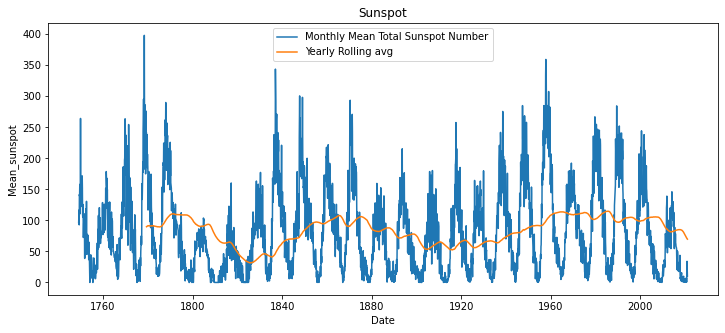

In [16]:
# set figure size
plt.figure( figsize = ( 12, 5))
  
# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot(x="Date", y="Mean_sunspot",
             data = df2,
             label = 'Monthly Mean Total Sunspot Number')
  
# plot using rolling average
sns.lineplot( x = 'Date',
             y = '1y_rolling_avg',
             data = df2,
             label = 'Yearly Rolling avg')
  
plt.title("Sunspot")
plt.show();

# Train test Split

Data split will have 80% train and 20% test

Observations: 3265
Training Observations: 2612
Testing Observations: 653


C:\Users\silvane.paixao\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


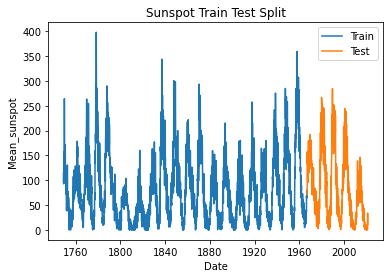

In [17]:
#Train test Split
train_ind = int(len(df)*0.8)
train = df[:train_ind]
test = df[train_ind:]

print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot(x="Date", y="Mean_sunspot",
             data = train,
             label = 'Train')
  
# plot using rolling average
sns.lineplot("Date", y="Mean_sunspot",
              data = test,
             label = 'Test')
  
plt.title("Sunspot Train Test Split")
plt.show();



## Scale

In [18]:
sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

X_train_sc = train_sc[:-1]
y_train_sc = train_sc[1:]

X_test_sc = test_sc[:-1]
y_test_sc = test_sc[1:]

print('Train: X=%s, y=%s' % (X_train_sc.shape, y_train_sc.shape))
print('Test: X=%s, y=%s' % (X_test_sc.shape, y_test_sc.shape))


Train: X=(2611, 1), y=(2611, 1)
Test: X=(652, 1), y=(652, 1)


## Sliding Window

In [19]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)

for s in range(1, 11):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)
    
X_train_s_sc = train_sc_df.dropna().drop('Scaled', axis=1)
y_train_s_sc = train_sc_df.dropna()[['Scaled']]

X_test_s_sc = test_sc_df.dropna().drop('Scaled', axis=1)
y_test_s_sc = test_sc_df.dropna()[['Scaled']]

print('Train: X=%s, y=%s' % (X_train_s_sc.shape, y_train_s_sc.shape))
print('Test: X=%s, y=%s' % (X_test_s_sc.shape, y_test_s_sc.shape))


print('X_train Scaled Sliding window')
X_train_s_sc.head()
print('X_test Scaled Sliding window')
X_test_s_sc.head()

Train: X=(2602, 10), y=(2602, 1)
Test: X=(643, 10), y=(643, 1)
X_train Scaled Sliding window


,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10
Date,,,,,,,,,,
1749-11-30,0.315922,0.317680,0.277499,0.396786,0.349573,0.355851,0.233049,0.293069,0.261929,0.242843
1749-12-31,0.663737,0.315922,0.317680,0.277499,0.396786,0.349573,0.355851,0.233049,0.293069,0.261929
1750-01-31,0.356605,0.663737,0.315922,0.317680,0.277499,0.396786,0.349573,0.355851,0.233049,0.293069
1750-02-28,0.306881,0.356605,0.663737,0.315922,0.317680,0.277499,0.396786,0.349573,0.355851,0.233049
1750-03-31,0.317680,0.306881,0.356605,0.663737,0.315922,0.317680,0.277499,0.396786,0.349573,0.355851


X_test Scaled Sliding window


,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10
Date,,,,,,,,,,
1967-07-31,0.239578,0.307634,0.247112,0.397539,0.332998,0.394274,0.250628,0.203415,0.203918,0.178553
1967-08-31,0.325213,0.239578,0.307634,0.247112,0.397539,0.332998,0.394274,0.250628,0.203415,0.203918
1967-09-30,0.381215,0.325213,0.239578,0.307634,0.247112,0.397539,0.332998,0.394274,0.250628,0.203415
1967-10-31,0.272978,0.381215,0.325213,0.239578,0.307634,0.247112,0.397539,0.332998,0.394274,0.250628
1967-11-30,0.313913,0.272978,0.381215,0.325213,0.239578,0.307634,0.247112,0.397539,0.332998,0.394274


# LSTM with sliding windows as input Features

In [20]:
X_train_s_sc = X_train_s_sc.to_numpy()
X_test_s_sc = X_test_s_sc.to_numpy()

# X_train_t --- > Transfomed Data
X_train_t = X_train_s_sc.reshape((X_train_s_sc.shape[0], 1, 10))
X_test_t = X_test_s_sc.reshape((X_test_s_sc.shape[0], 1, 10))



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 240       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________
Epoch 23: early stopping
Test loss: 0.0033520120196044445
Test accuracy: 0.003261782694607973


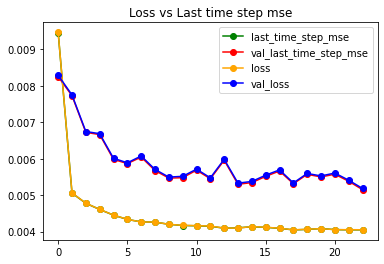

21/21 [==============================] - 0s 1ms/step
Mean Square Error:0.003
Root Mean Square Error:0.058


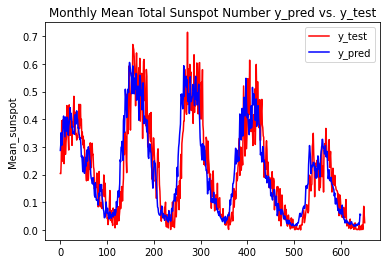

In [21]:
def last_time_step_mse(Y_true, Y_pred):
    return mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

K.clear_session()
model = Sequential()

model.add(LSTM(4, input_shape=(1, 10)))
model.add(Dense(1))
model.summary()


dflist = [] 

model.compile(loss='mean_squared_error',
                            optimizer='adam', metrics=[last_time_step_mse])

earlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,verbose=1)

h = model.fit(X_train_t, y_train_s_sc, batch_size=8, verbose=0, epochs=30, validation_split=0.1,callbacks=[earlyStopping_callback])

       
dflist.append(pd.DataFrame(h.history, index=h.epoch))

score = model.evaluate(X_test_t, y_test_s_sc, verbose=0) 
print("Test loss:", score[0])
print("Test accuracy:", score[1])


plt.plot(figsize=(8, 5))
plt.plot(h.history['last_time_step_mse'], 'o-', label="last_time_step_mse", color = 'green')
plt.plot(h.history['val_last_time_step_mse'], 'o-', label="val_last_time_step_mse", color = 'red')
plt.plot(h.history['loss'], 'o-', label="loss", color = 'orange')
plt.plot(h.history['val_loss'], 'o-', label="val_loss", color = 'blue')
plt.title("Loss vs Last time step mse")
plt.legend()
plt.show();
          
y_pred = model.predict(X_test_t)

#calculate the MSE & RMSE
MSE = np.square(np.subtract(np.array(y_test_s_sc), np.array(y_pred))).mean() 
print("Mean Square Error:{0:.3f}".format(MSE))
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:{0:.3f}".format(RMSE))

plt.plot(y_test_sc[:,0], color = 'red', label = 'y_test')
plt.plot(y_pred[:,0], color = 'blue', label = 'y_pred')
plt.title('Monthly Mean Total Sunspot Number y_pred vs. y_test')
plt.ylabel('Mean_sunspot')
plt.legend()
plt.show();




# GRUs

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4)                 192       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.0032882913947105408
Test accuracy: 0.0032037266064435244


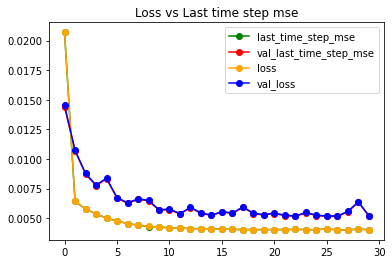

21/21 [==============================] - 0s 1ms/step
Mean Square Error:0.003
Root Mean Square Error:0.057


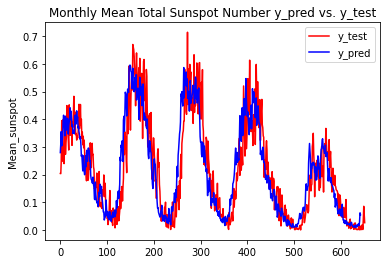

In [22]:
K.clear_session()
model2 = Sequential()

model2.add(GRU(4, input_shape=(1, 10)))
model2.add((Dense(1)))
model2.summary()


dflist2 = [] 

model2.compile(loss='mean_squared_error',
                            optimizer='adam', metrics=[last_time_step_mse])

earlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,verbose=1)

h2 = model2.fit(X_train_t, y_train_s_sc, batch_size=8, verbose=0, epochs=30, validation_split=0.1,callbacks=[earlyStopping_callback])

       
dflist2.append(pd.DataFrame(h2.history, index=h2.epoch))

score2 = model2.evaluate(X_test_t, y_test_s_sc, verbose=0) 
print("Test loss:", score2[0])
print("Test accuracy:", score2[1])


plt.plot(figsize=(8, 5))
plt.plot(h2.history['last_time_step_mse'], 'o-', label="last_time_step_mse", color = 'green')
plt.plot(h2.history['val_last_time_step_mse'], 'o-', label="val_last_time_step_mse", color = 'red')
plt.plot(h2.history['loss'], 'o-', label="loss", color = 'orange')
plt.plot(h2.history['val_loss'], 'o-', label="val_loss", color = 'blue')
plt.title("Loss vs Last time step mse")
plt.legend()
plt.show();
          
y_pred2 = model2.predict(X_test_t)

#calculate the MSE & RMSE
MSE = np.square(np.subtract(np.array(y_test_s_sc), np.array(y_pred2))).mean() 
print("Mean Square Error:{0:.3f}".format(MSE))
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:{0:.3f}".format(RMSE))


plt.plot(y_test_sc[:,0], color = 'red', label = 'y_test')
plt.plot(y_pred2[:,0], color = 'blue', label = 'y_pred')
plt.title('Monthly Mean Total Sunspot Number y_pred vs. y_test')
plt.ylabel('Mean_sunspot')
plt.legend()
plt.show();


# Simple RNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 10)             210       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 2)              26        
                                                                 
 dense (Dense)               (None, 1, 1)              3         
                                                                 
Total params: 239
Trainable params: 239
Non-trainable params: 0
_________________________________________________________________
Epoch 18: early stopping
Test loss: 0.003492973046377301
Test accuracy: 0.0034033514093607664


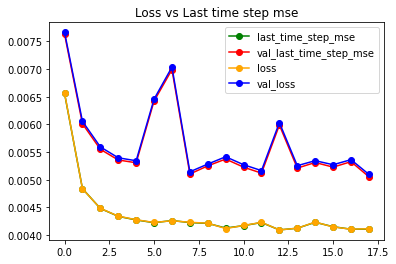

21/21 [==============================] - 0s 1ms/step
Mean Square Error:0.003
Root Mean Square Error:0.058


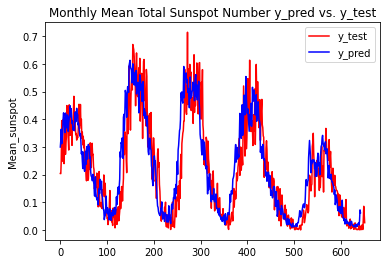

In [23]:
K.clear_session()
model3 = Sequential()


model3.add(SimpleRNN(10,return_sequences=True, input_shape=(1, 10)))
model3.add(SimpleRNN(2,return_sequences=True))
model3.add((Dense(1)))
model3.summary()

dflist3 = [] 

model3.compile(loss='mean_squared_error',
                            optimizer='adam', metrics=[last_time_step_mse])

earlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,verbose=1)

h3 = model3.fit(X_train_t, y_train_s_sc, batch_size=8, verbose=0, epochs=30, validation_split=0.1,callbacks=[earlyStopping_callback])

       
dflist3.append(pd.DataFrame(h3.history, index=h3.epoch))

score3 = model3.evaluate(X_test_t, y_test_s_sc, verbose=0) 
print("Test loss:", score3[0])
print("Test accuracy:", score3[1])


plt.plot(figsize=(8, 5))
plt.plot(h3.history['last_time_step_mse'], 'o-', label="last_time_step_mse", color = 'green')
plt.plot(h3.history['val_last_time_step_mse'], 'o-', label="val_last_time_step_mse", color = 'red')
plt.plot(h3.history['loss'], 'o-', label="loss", color = 'orange')
plt.plot(h3.history['val_loss'], 'o-', label="val_loss", color = 'blue')
plt.title("Loss vs Last time step mse")
plt.legend()
plt.show();
          
y_pred3 = model3.predict(X_test_t)

#calculate the MSE & RMSE
MSE = np.square(np.subtract(np.array(y_test_s_sc), np.array(y_pred))).mean() 
print("Mean Square Error:{0:.3f}".format(MSE))
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:{0:.3f}".format(RMSE))


plt.plot(y_test_sc[:,0], color = 'red', label = 'y_test')
plt.plot(y_pred3[:,0], color = 'blue', label = 'y_pred')
plt.title('Monthly Mean Total Sunspot Number y_pred vs. y_test')
plt.ylabel('Mean_sunspot')
plt.legend()
plt.show();
